## This study follows the deployment framework of [1] and uses the Lycos-IDS2017 dataset of [2]

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score, roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
path = os.getcwd()

In [3]:
benign = pd.read_csv(f'{path}/data/Monday-WorkingHours.pcap_lycos.csv')

In [4]:
benign.head()

,flow_id,src_addr,src_port,dst_addr,dst_port,ip_prot,timestamp,flow_duration,down_up_ratio,pkt_len_max,pkt_len_min,pkt_len_mean,pkt_len_var,pkt_len_std,bytes_per_s,pkt_per_s,fwd_pkt_per_s,bwd_pkt_per_s,fwd_pkt_cnt,fwd_pkt_len_tot,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,fwd_pkt_hdr_len_tot,fwd_pkt_hdr_len_min,fwd_non_empty_pkt_cnt,bwd_pkt_cnt,bwd_pkt_len_tot,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,bwd_pkt_hdr_len_tot,bwd_pkt_hdr_len_min,bwd_non_empty_pkt_cnt,iat_max,iat_min,iat_mean,iat_std,fwd_iat_tot,fwd_iat_max,fwd_iat_min,fwd_iat_mean,fwd_iat_std,bwd_iat_tot,bwd_iat_max,bwd_iat_min,bwd_iat_mean,bwd_iat_std,active_max,active_min,active_mean,active_std,idle_max,idle_min,idle_mean,idle_std,flag_SYN,flag_fin,flag_rst,flag_ack,flag_psh,fwd_flag_psh,bwd_flag_psh,flag_urg,fwd_flag_urg,bwd_flag_urg,flag_cwr,flag_ece,fwd_bulk_bytes_mean,fwd_bulk_pkt_mean,fwd_bulk_rate_mean,bwd_bulk_bytes_mean,bwd_bulk_pkt_mean,bwd_bulk_rate_mean,fwd_subflow_bytes_mean,fwd_subflow_pkt_mean,bwd_subflow_bytes_mean,bwd_subflow_pkt_mean,fwd_tcp_init_win_bytes,bwd_tcp_init_win_bytes,label
0,224.0.0.22-192.168.10.9-0-0-2,224.0.0.22,0,192.168.10.9,0,2,1499082997567312,84524,0.000000,8.0,8.0,8.00,0.000000,0.000000,3.785907e+02,47.323837,0.000000,47.323837,0,0,0.0,0.0,0.000000,0.000000,0,0,0,4,32,8.0,8.0,8.000000,0.000000,32,8,4,83220.0,160.0,2.817467e+04,4.767320e+04,0,0.0,0.0,0.000000e+00,0.000000e+00,84524,83220.0,160.0,2.817467e+04,4.767320e+04,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000e+00,32.000000,4.000000,378.590696,0.0,0.0,32.0,4.0,-1,-1,benign
1,192.168.10.9-224.0.0.252-60372-5355-17,192.168.10.9,60372,224.0.0.252,5355,17,1499082997568863,98644,0.000000,28.0,28.0,28.00,0.000000,0.000000,5.109282e+03,182.474352,182.474352,0.000000,18,504,28.0,28.0,28.000000,0.000000,144,8,18,0,0,0.0,0.0,0.000000,0.000000,0,0,0,98619.0,1.0,5.802588e+03,2.391824e+04,98644,98619.0,1.0,5.802588e+03,2.391824e+04,0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,504.0,18.0,5.109282e+03,0.000000,0.000000,0.000000,504.0,18.0,0.0,0.0,-1,-1,benign
2,192.168.10.9-192.168.10.3-137-137-17,192.168.10.9,137,192.168.10.3,137,17,1499082997897192,83068408,1.105263,68.0,50.0,59.15,43.724051,6.612416,5.696510e+01,0.963062,0.457454,0.505607,38,2224,68.0,50.0,58.526316,9.108169,304,8,38,42,2508,62.0,0.0,59.714286,2.949045,336,8,42,50778435.0,1.0,1.051499e+06,5.971943e+06,83068326,50778573.0,1.0,2.245090e+06,8.632611e+06,83068177,50778563.0,1.0,2.026053e+06,8.217163e+06,14874848.0,1502094.0,8188471.0,9.455965e+06,50778435.0,15888498.0,33333466.5,2.467091e+07,0,0,0,0,0,0,0,0,0,0,0,0,408.0,6.0,6.181818e+06,281.333333,4.666667,14842.170052,222.4,3.8,250.8,4.2,-1,-1,benign
3,192.168.10.9-192.168.10.3-63683-53-17,192.168.10.9,63683,192.168.10.3,53,17,1499082997908429,292,1.000000,131.0,81.0,106.00,833.333333,28.867513,1.452055e+06,13698.630137,6849.315068,6849.315068,2,162,81.0,81.0,81.000000,0.000000,16,8,2,2,262,131.0,0.0,131.000000,0.000000,16,8,2,286.0,3.0,9.733333e+01,1.633901e+02,3,3.0,3.0,3.000000e+00,0.000000e+00,3,3.0,3.0,3.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,162.0,2.0,262.0,2.0,-1,-1,benign
4,192.168.10.9-192.168.10.3-63276-53-17,192.168.10.9,63276,192.168.10.3,53,17,1499082997908639,293,1.000000,131.0,81.0,106.00,833.333333,28.867513,1.447099e+06,13651.877133,6825.938567,6825.938567,2,162,81.0,81.0,81.000000,0.000000,16,8,2,2,262,131.0,0.0,131.000000,0.000000,16,8,2,196.0,48.0,9.766667e+01,8.516063e+01,49,49.0,49.0,4.900000e+01,0.000000e+00,48,48.0,48.0,4.800000e+01,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000e+00,0.000000,0.000000,0.000000,162.0,2.0,262.0,2.0,-1,-1,benign


In [5]:
benign['label'].unique()

array(['benign'], dtype=object)

In [6]:
tuesday = pd.read_csv(f'{path}/data/Tuesday-WorkingHours.pcap_lycos.csv')

In [7]:
wednesday = pd.read_csv(f'{path}/data/Wednesday-WorkingHours.pcap_lycos.csv')

In [8]:
thursday = pd.read_csv(f'{path}/data/Thursday-WorkingHours.pcap_lycos.csv')

In [9]:
friday = pd.read_csv(f'{path}/data/Friday-WorkingHours.pcap_lycos.csv')

In [10]:
attack = pd.concat([tuesday, wednesday, thursday, friday], ignore_index=True)

In [11]:
attack.head()

,flow_id,src_addr,src_port,dst_addr,dst_port,ip_prot,timestamp,flow_duration,down_up_ratio,pkt_len_max,pkt_len_min,pkt_len_mean,pkt_len_var,pkt_len_std,bytes_per_s,pkt_per_s,fwd_pkt_per_s,bwd_pkt_per_s,fwd_pkt_cnt,fwd_pkt_len_tot,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,fwd_pkt_hdr_len_tot,fwd_pkt_hdr_len_min,fwd_non_empty_pkt_cnt,bwd_pkt_cnt,bwd_pkt_len_tot,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,bwd_pkt_hdr_len_tot,bwd_pkt_hdr_len_min,bwd_non_empty_pkt_cnt,iat_max,iat_min,iat_mean,iat_std,fwd_iat_tot,fwd_iat_max,fwd_iat_min,fwd_iat_mean,fwd_iat_std,bwd_iat_tot,bwd_iat_max,bwd_iat_min,bwd_iat_mean,bwd_iat_std,active_max,active_min,active_mean,active_std,idle_max,idle_min,idle_mean,idle_std,flag_SYN,flag_fin,flag_rst,flag_ack,flag_psh,fwd_flag_psh,bwd_flag_psh,flag_urg,fwd_flag_urg,bwd_flag_urg,flag_cwr,flag_ece,fwd_bulk_bytes_mean,fwd_bulk_pkt_mean,fwd_bulk_rate_mean,bwd_bulk_bytes_mean,bwd_bulk_pkt_mean,bwd_bulk_rate_mean,fwd_subflow_bytes_mean,fwd_subflow_pkt_mean,bwd_subflow_bytes_mean,bwd_subflow_pkt_mean,fwd_tcp_init_win_bytes,bwd_tcp_init_win_bytes,label
0,192.168.10.3-192.168.10.5-445-49159-6,192.168.10.3,445,192.168.10.5,49159,6,1499169224398274,90030854,1.000000,1.0,0.0,0.500000,0.263158,0.512989,1.110730e-01,0.222146,0.111073,0.111073,10,2,1.0,0.0,0.200000,0.421637,296,20,2,10,8,1.0,0.0,0.8,0.421637,224,20,8,30013373.0,3.0,4738466.0,1.123277e+07,90030800,30013419.0,3.0,1.000342e+07,1.498814e+07,90030813,30013426.0,3.0,1.000342e+07,1.498812e+07,68162.0,57.0,22761.333333,39318.130886,30013373.0,29946916.0,2.998751e+07,35592.500114,0,0,0,20,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,2.5,2.0,2.5,2049,254,benign
1,192.168.10.5-192.168.10.3-63729-389-17,192.168.10.5,63729,192.168.10.3,389,17,1499169250020688,225,1.000000,207.0,163.0,185.000000,645.333333,25.403412,3.288889e+06,17777.777778,8888.888889,8888.888889,2,414,207.0,207.0,207.000000,0.000000,16,8,2,2,326,163.0,0.0,163.0,0.000000,16,8,2,217.0,4.0,75.0,1.229756e+02,4,4.0,4.0,4.000000e+00,0.000000e+00,4,4.0,4.0,4.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,414.0,2.0,326.0,2.0,-1,-1,benign
2,192.168.10.5-192.168.10.3-49182-88-6,192.168.10.5,49182,192.168.10.3,88,6,1499169250131297,640,0.571429,220.0,0.0,72.545455,10299.072727,101.484347,1.246875e+06,17187.500000,10937.500000,6250.000000,7,440,220.0,0.0,62.857143,107.349008,164,20,2,4,358,179.0,0.0,89.5,103.345698,104,20,2,445.0,1.0,64.0,1.355573e+02,640,497.0,1.0,1.066667e+02,1.943252e+02,538,530.0,4.0,1.793333e+02,3.036862e+02,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,4,1,0,9,4,2,2,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,440.0,7.0,358.0,4.0,8192,8192,benign
3,192.168.10.5-192.168.10.3-49183-88-6,192.168.10.5,49183,192.168.10.3,88,6,1499169250139647,900,0.444444,1472.0,0.0,272.615385,295618.256410,543.707878,3.937778e+06,14444.444444,10000.000000,4444.444444,9,600,300.0,0.0,66.666667,132.287566,204,20,2,4,2944,1472.0,0.0,736.0,849.859596,104,20,2,684.0,1.0,75.0,1.927952e+02,900,734.0,1.0,1.125000e+02,2.524112e+02,766,758.0,3.0,2.553333e+02,4.353233e+02,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,4,1,0,11,4,2,2,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,9.0,2944.0,4.0,8192,8192,benign
4,192.168.10.5-192.168.10.3-49184-88-6,192.168.10.5,49184,192.168.10.3,88,6,1499169250140755,1205,0.571429,1415.0,0.0,509.636364,500051.654545,707.143306,4.652282e+06,9128.630705,5809.128631,3319.502075,7,2776,1388.0,0.0,396.571429,677.274651,164,20,2,4,2830,1415.0,0.0,707.5,816.950631,104,20,2,777.0,1.0,120.5,2.364333e+02,1205,1008.0,1.0,2.008333e+02,3.970584e+02,927,876.0,1.0,3.090000e+02,4.916472e+02,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,4,1,0,9,4,2,2,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2776.0,7.0,2830.0,4.0,8192,8192,benign


In [12]:
attack['label'].unique()

array(['benign', 'ftp_patator', 'ssh_patator', 'dos_slowloris',
       'dos_slowhttptest', 'dos_hulk', 'dos_goldeneye', 'heartbleed',
       'webattack_bruteforce', 'webattack_xss', 'webattack_sql_injection',
       'bot', 'portscan', 'ddos'], dtype=object)

In [13]:
print(benign.shape, attack.shape)

(367181, 83) (1470317, 83)


In [14]:
attack['ip_prot'].unique()

array([  6,  17,   1,   2, 132])

In [15]:
df = pd.concat([benign, attack], ignore_index=True)

In [16]:
df.describe()

,src_port,dst_port,ip_prot,timestamp,flow_duration,down_up_ratio,pkt_len_max,pkt_len_min,pkt_len_mean,pkt_len_var,pkt_len_std,bytes_per_s,pkt_per_s,fwd_pkt_per_s,bwd_pkt_per_s,fwd_pkt_cnt,fwd_pkt_len_tot,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,fwd_pkt_hdr_len_tot,fwd_pkt_hdr_len_min,fwd_non_empty_pkt_cnt,bwd_pkt_cnt,bwd_pkt_len_tot,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,bwd_pkt_hdr_len_tot,bwd_pkt_hdr_len_min,bwd_non_empty_pkt_cnt,iat_max,iat_min,iat_mean,iat_std,fwd_iat_tot,fwd_iat_max,fwd_iat_min,fwd_iat_mean,fwd_iat_std,bwd_iat_tot,bwd_iat_max,bwd_iat_min,bwd_iat_mean,bwd_iat_std,active_max,active_min,active_mean,active_std,idle_max,idle_min,idle_mean,idle_std,flag_SYN,flag_fin,flag_rst,flag_ack,flag_psh,fwd_flag_psh,bwd_flag_psh,flag_urg,fwd_flag_urg,bwd_flag_urg,flag_cwr,flag_ece,fwd_bulk_bytes_mean,fwd_bulk_pkt_mean,fwd_bulk_rate_mean,bwd_bulk_bytes_mean,bwd_bulk_pkt_mean,bwd_bulk_rate_mean,fwd_subflow_bytes_mean,fwd_subflow_pkt_mean,bwd_subflow_bytes_mean,bwd_subflow_pkt_mean,fwd_tcp_init_win_bytes,bwd_tcp_init_win_bytes
count,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1837498.0,1837498.0,1837498.0,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06
mean,4.851412e+04,1.016174e+03,1.131388e+01,1.499277e+15,1.199375e+07,1.051375e+00,1.388679e+03,2.117446e+01,3.051886e+02,9.484971e+05,4.775796e+02,5.902847e+05,1.233599e+04,7.515683e+03,4.820309e+03,1.214130e+01,5.751877e+02,2.156581e+02,2.143513e+01,6.066870e+01,7.115022e+01,2.770368e+02,1.793393e+01,2.751816e+00,1.467427e+01,2.396352e+04,1.351654e+03,1.550679e-01,4.759030e+02,5.322375e+02,3.280494e+02,1.684333e+01,1.268193e+01,4.592725e+06,1.820236e+04,8.792799e+05,1.721531e+06,1.163050e+07,4.417167e+06,1.214749e+06,2.005897e+06,1.244304e+06,1.091002e+07,3.891474e+06,1.353950e+06,2.072981e+06,9.999340e+05,1.827067e+05,6.236271e+04,9.085547e+04,5.248137e+04,4.033050e+06,3.658133e+06,3.855138e+06,2.046651e+05,9.387292e-01,3.834197e-01,9.971603e-02,2.442314e+01,3.168392e+00,1.415754e+00,1.752638e+00,0.0,0.0,0.0,4.087079e-04,6.057149e-04,6.775367e+01,2.369940e-01,1.821951e+05,4.215857e+03,2.093305e+00,2.855677e+06,2.681484e+02,6.813951e+00,1.395996e+04,8.270970e+00,1.069511e+04,1.146236e+04
std,1.580724e+04,5.216598e+03,5.542912e+00,1.302638e+11,3.091508e+07,4.082071e-01,2.375817e+03,2.643862e+01,4.622562e+02,2.627050e+06,8.487727e+02,8.554230e+06,6.437455e+04,5.069289e+04,2.674976e+04,9.299889e+02,5.453320e+03,4.787516e+02,3.567512e+01,9.875525e+01,1.549067e+02,1.943498e+04,1.079900e+01,6.477690e+00,1.237128e+03,2.807826e+06,2.364553e+03,6.027267e+00,7.377988e+02,1.044318e+03,2.477432e+04,9.914960e+00,1.236598e+03,1.427997e+07,2.505621e+05,3.445050e+06,6.219367e+06,3.078804e+07,1.426006e+07,9.487244e+06,9.758034e+06,4.235076e+06,3.004978e+07,1.377562e+07,9.815013e+06,1.020862e+07,4.199289e+06,1.104878e+06,6.403329e+05,7.130510e+05,4.322259e+05,1.401476e+07,1.336863e+07,1.356828e+07,2.171198e+06,1.059359e+00,4.862193e-01,2.996211e-01,2.166668e+03,2.880648e+01,4.787257e+00,2.694965e+01,0.0,0.0,0.0,2.888114e-02,3.414518e-02,1.404031e+03,1.642841e+00,4.

# Create the full dataset for save keeping

In [17]:
# Uncomment following line if you haven't already saved the port scan data set
#df.to_csv('full_lycosids2017.csv', index=False)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1837498 entries, 0 to 1837497
Data columns (total 83 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   flow_id                 object 
 1   src_addr                object 
 2   src_port                int64  
 3   dst_addr                object 
 4   dst_port                int64  
 5   ip_prot                 int64  
 6   timestamp               int64  
 7   flow_duration           int64  
 8   down_up_ratio           float64
 9   pkt_len_max             float64
 10  pkt_len_min             float64
 11  pkt_len_mean            float64
 12  pkt_len_var             float64
 13  pkt_len_std             float64
 14  bytes_per_s             float64
 15  pkt_per_s               float64
 16  fwd_pkt_per_s           float64
 17  bwd_pkt_per_s           float64
 18  fwd_pkt_cnt             int64  
 19  fwd_pkt_len_tot         int64  
 20  fwd_pkt_len_max         float64
 21  fwd_pkt_len_min         float64

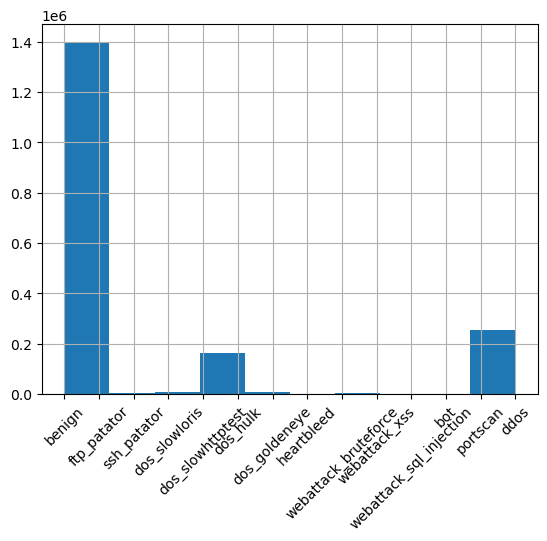

In [19]:
df['label'].hist(xrot=45)
plt.show()

In [20]:
df['label'].value_counts()

label
benign                     1395675
portscan                    160106
dos_hulk                    158988
ddos                         95683
dos_goldeneye                 6765
dos_slowloris                 5674
dos_slowhttptest              4866
ftp_patator                   4003
ssh_patator                   2959
webattack_bruteforce          1360
bot                            735
webattack_xss                  661
webattack_sql_injection         12
heartbleed                      11
Name: count, dtype: int64

In [21]:
df['ip_prot'].unique()

array([  2,  17,   6,   1, 132])

In [22]:
df=df[df['ip_prot']==6] # consider only TCP protocol

### Following features are removed [2]
- flow_id: redundant with other features
- src_addr: not relevant and can be learned
- dst_addr: ditto
- src_port: ditto
- timestamp: avoid learning timeperiods when attacks occur

In [23]:
columns_var=['flow_id', 'src_addr', 'dst_addr', 'src_port', 'timestamp'] # features not applicable to this study
df.drop(columns=columns_var,axis=1,inplace=True)

### Features to keep [2]
- Destinaton port
- IPv4 protocol
- Flow duration
- Downlink/uplink ration
- Maximal lenght among all packets of the flow
- Byte per second rate for this flow
- Packet per second rate for this flow
- Count of forward packets
- Total length of forward packets of the flow
- Maximal length among forward packets of the flow

In [24]:
columns_var=['dst_port', 'ip_prot', 'flow_duration', 'down_up_ratio', 'pkt_len_max', 'bytes_per_s', 'pkt_per_s', 'fwd_pkt_cnt', 'fwd_pkt_len_tot', 'fwd_pkt_len_max', 'label']
df = df[columns_var]

In [25]:
# check features with zero variance (not useful for learning)
features = df.drop(columns = ["label"])
features.var() == 0

dst_port           False
ip_prot            False
flow_duration      False
down_up_ratio      False
pkt_len_max        False
bytes_per_s        False
pkt_per_s          False
fwd_pkt_cnt        False
fwd_pkt_len_tot    False
fwd_pkt_len_max    False
dtype: bool

In [26]:
features.isna().sum() # check for missing values

dst_port           0
ip_prot            0
flow_duration      0
down_up_ratio      0
pkt_len_max        0
bytes_per_s        0
pkt_per_s          0
fwd_pkt_cnt        0
fwd_pkt_len_tot    0
fwd_pkt_len_max    0
dtype: int64

In [27]:
features.isnull().sum() # check for nan

dst_port           0
ip_prot            0
flow_duration      0
down_up_ratio      0
pkt_len_max        0
bytes_per_s        0
pkt_per_s          0
fwd_pkt_cnt        0
fwd_pkt_len_tot    0
fwd_pkt_len_max    0
dtype: int64

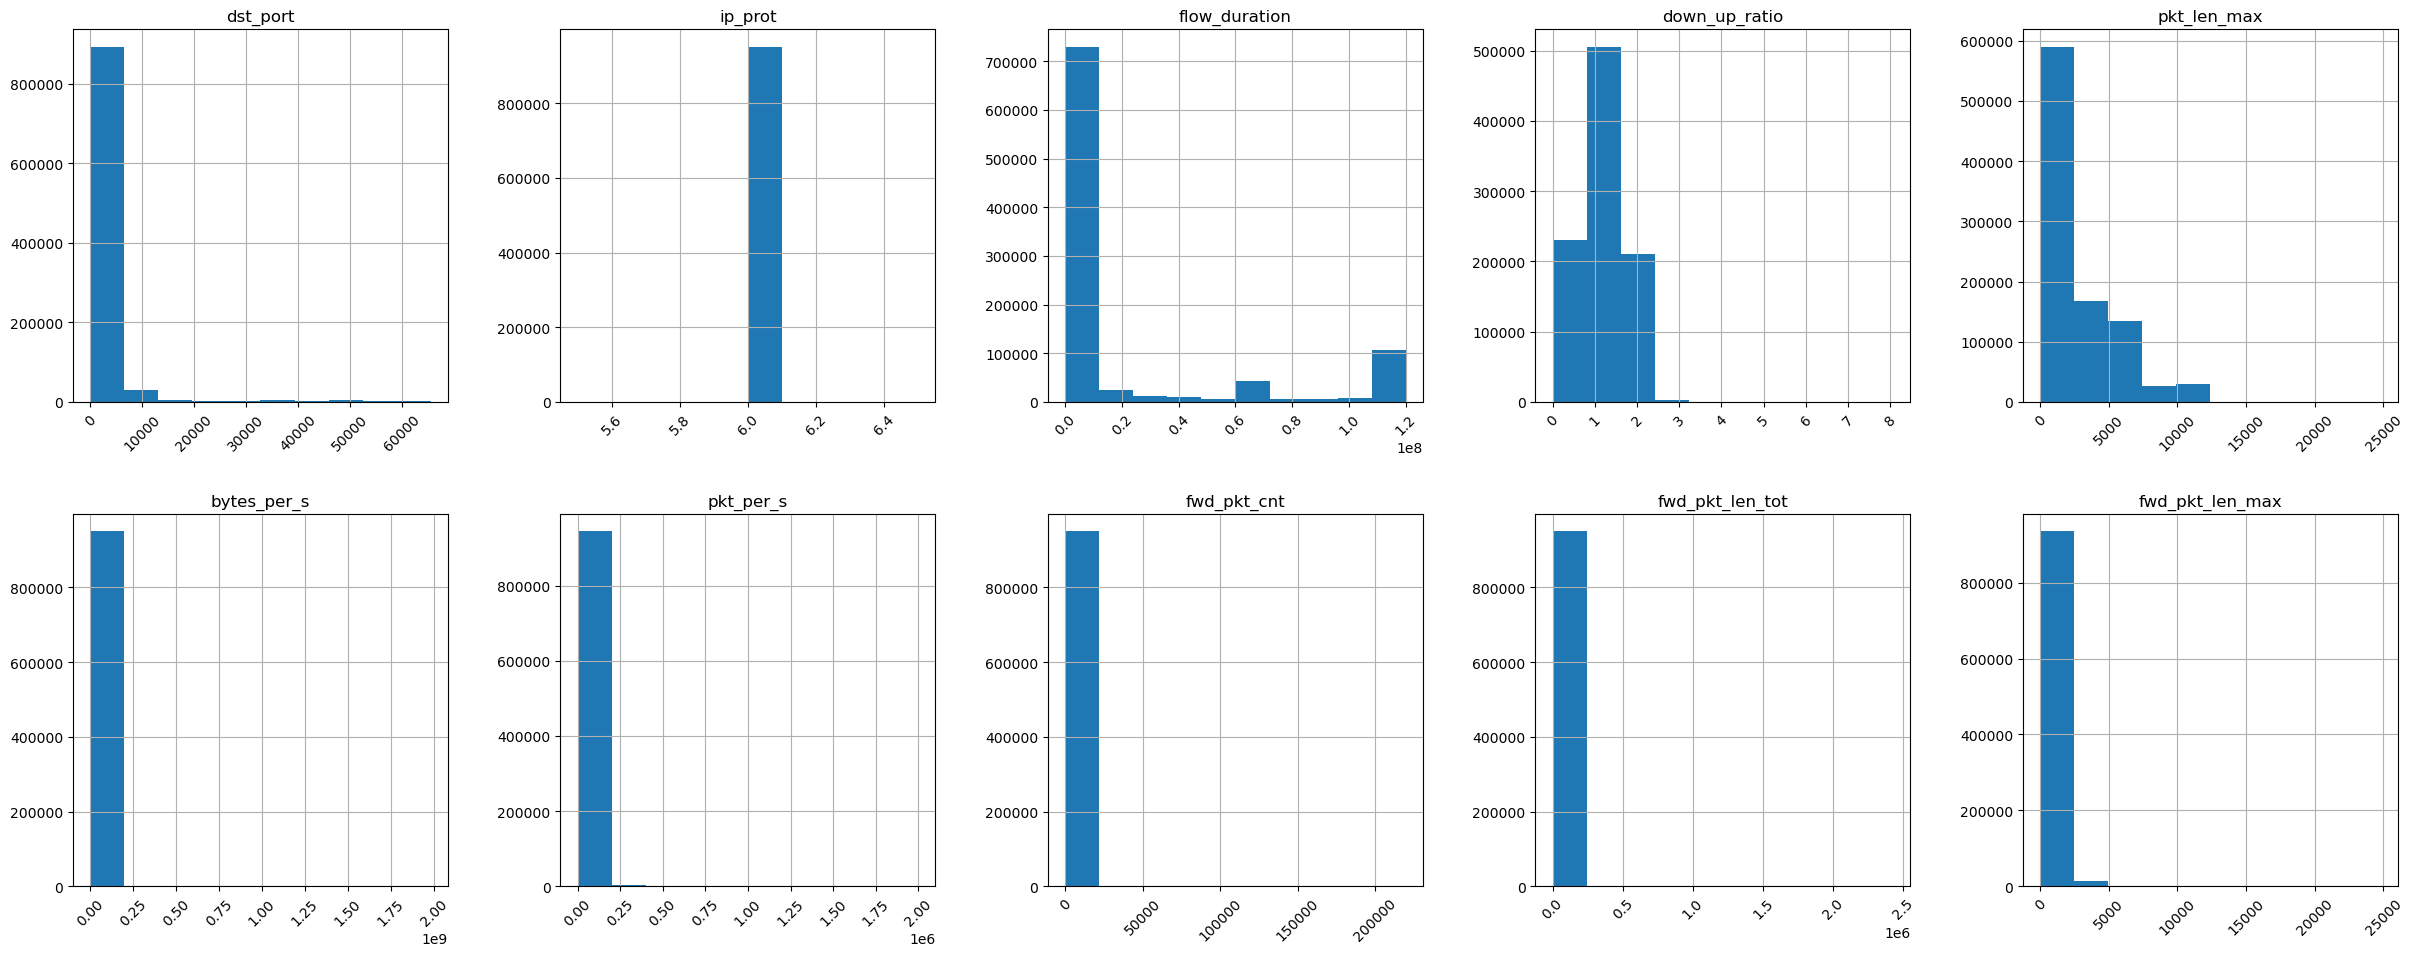

In [28]:
# histograms
df.hist(figsize=(30,30), layout=(5,5),sharex=False, sharey=False, xlabelsize=None, ylabelsize=None, xrot=45)
plt.show()

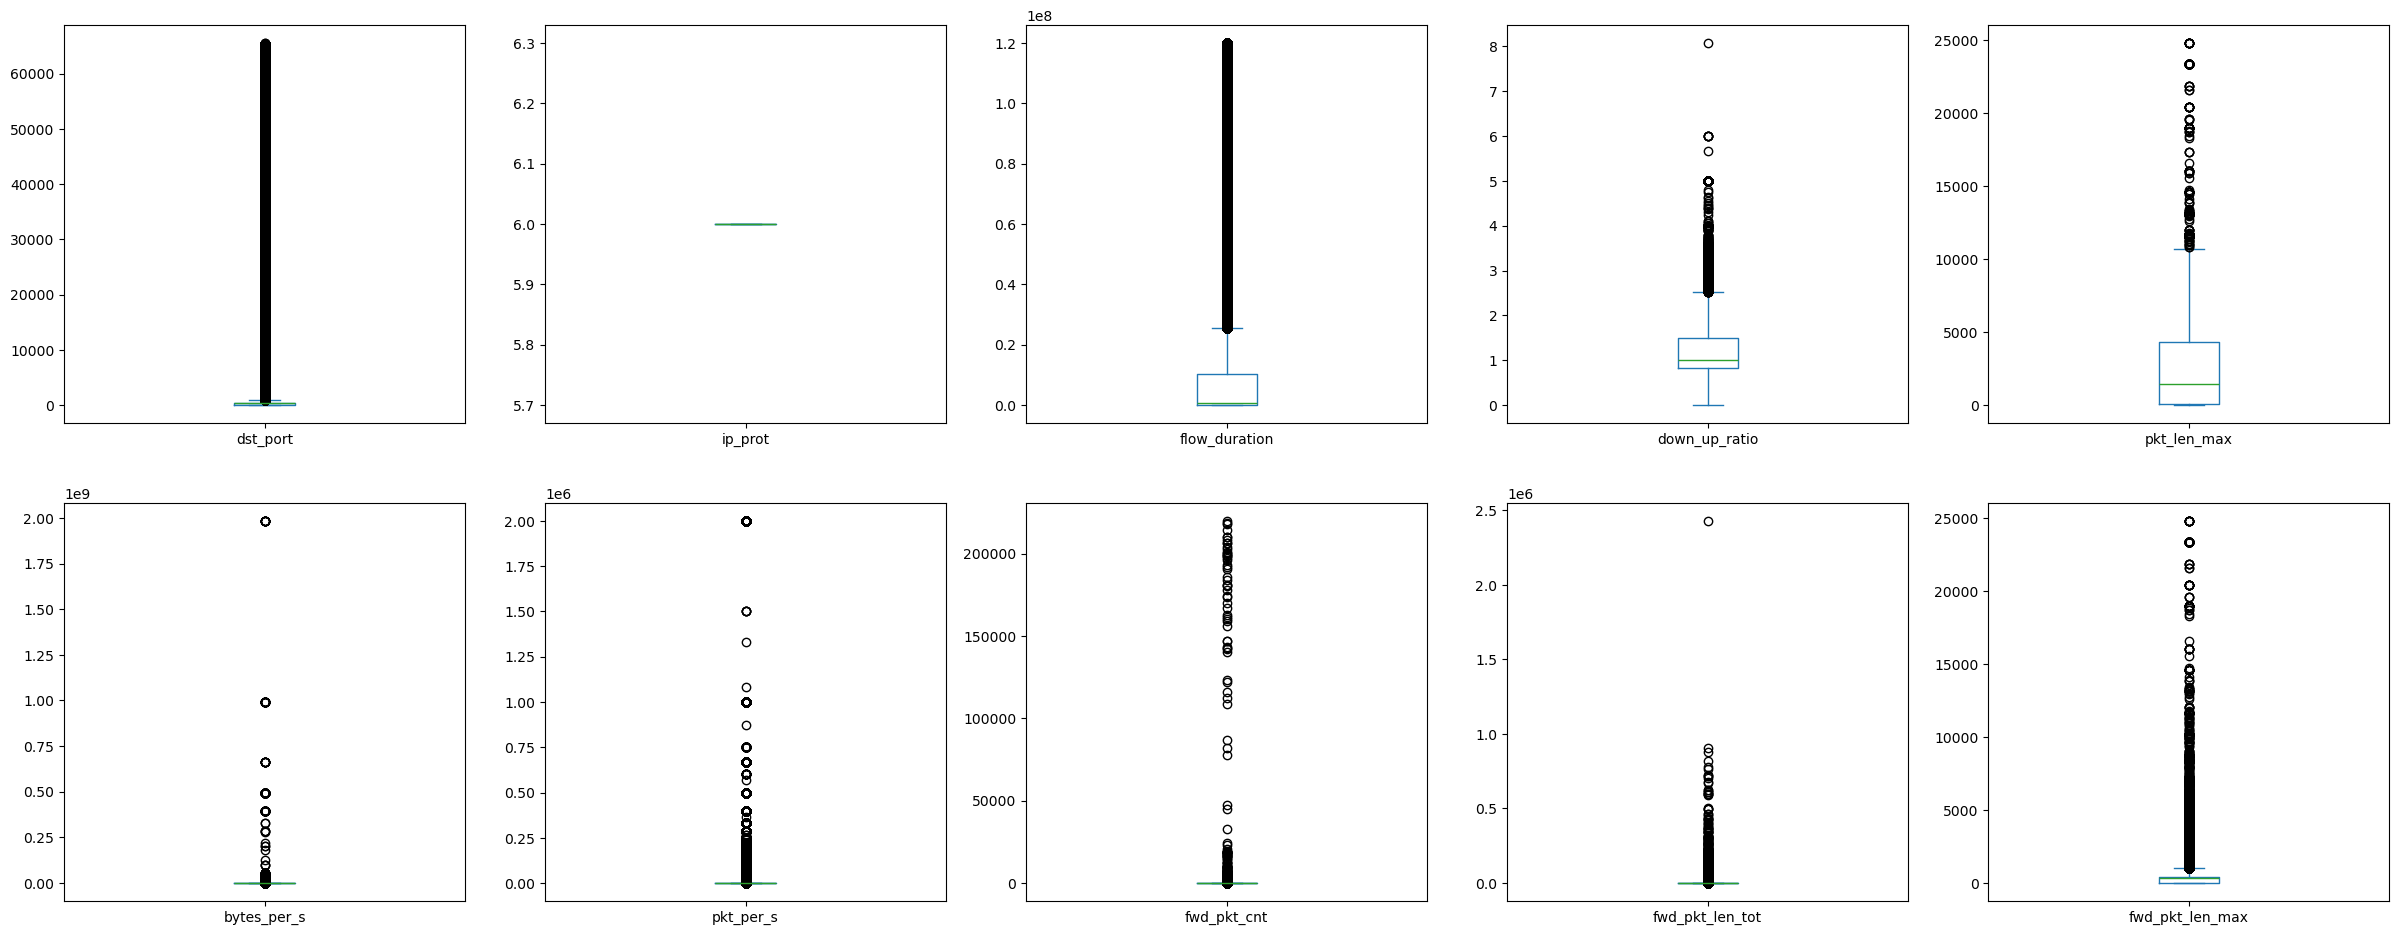

In [29]:
# box and whisker plots
df.plot(kind='box', subplots=True, figsize=(30,30), layout=(5,5), sharex=False, sharey=False,
fontsize=None)
plt.show()

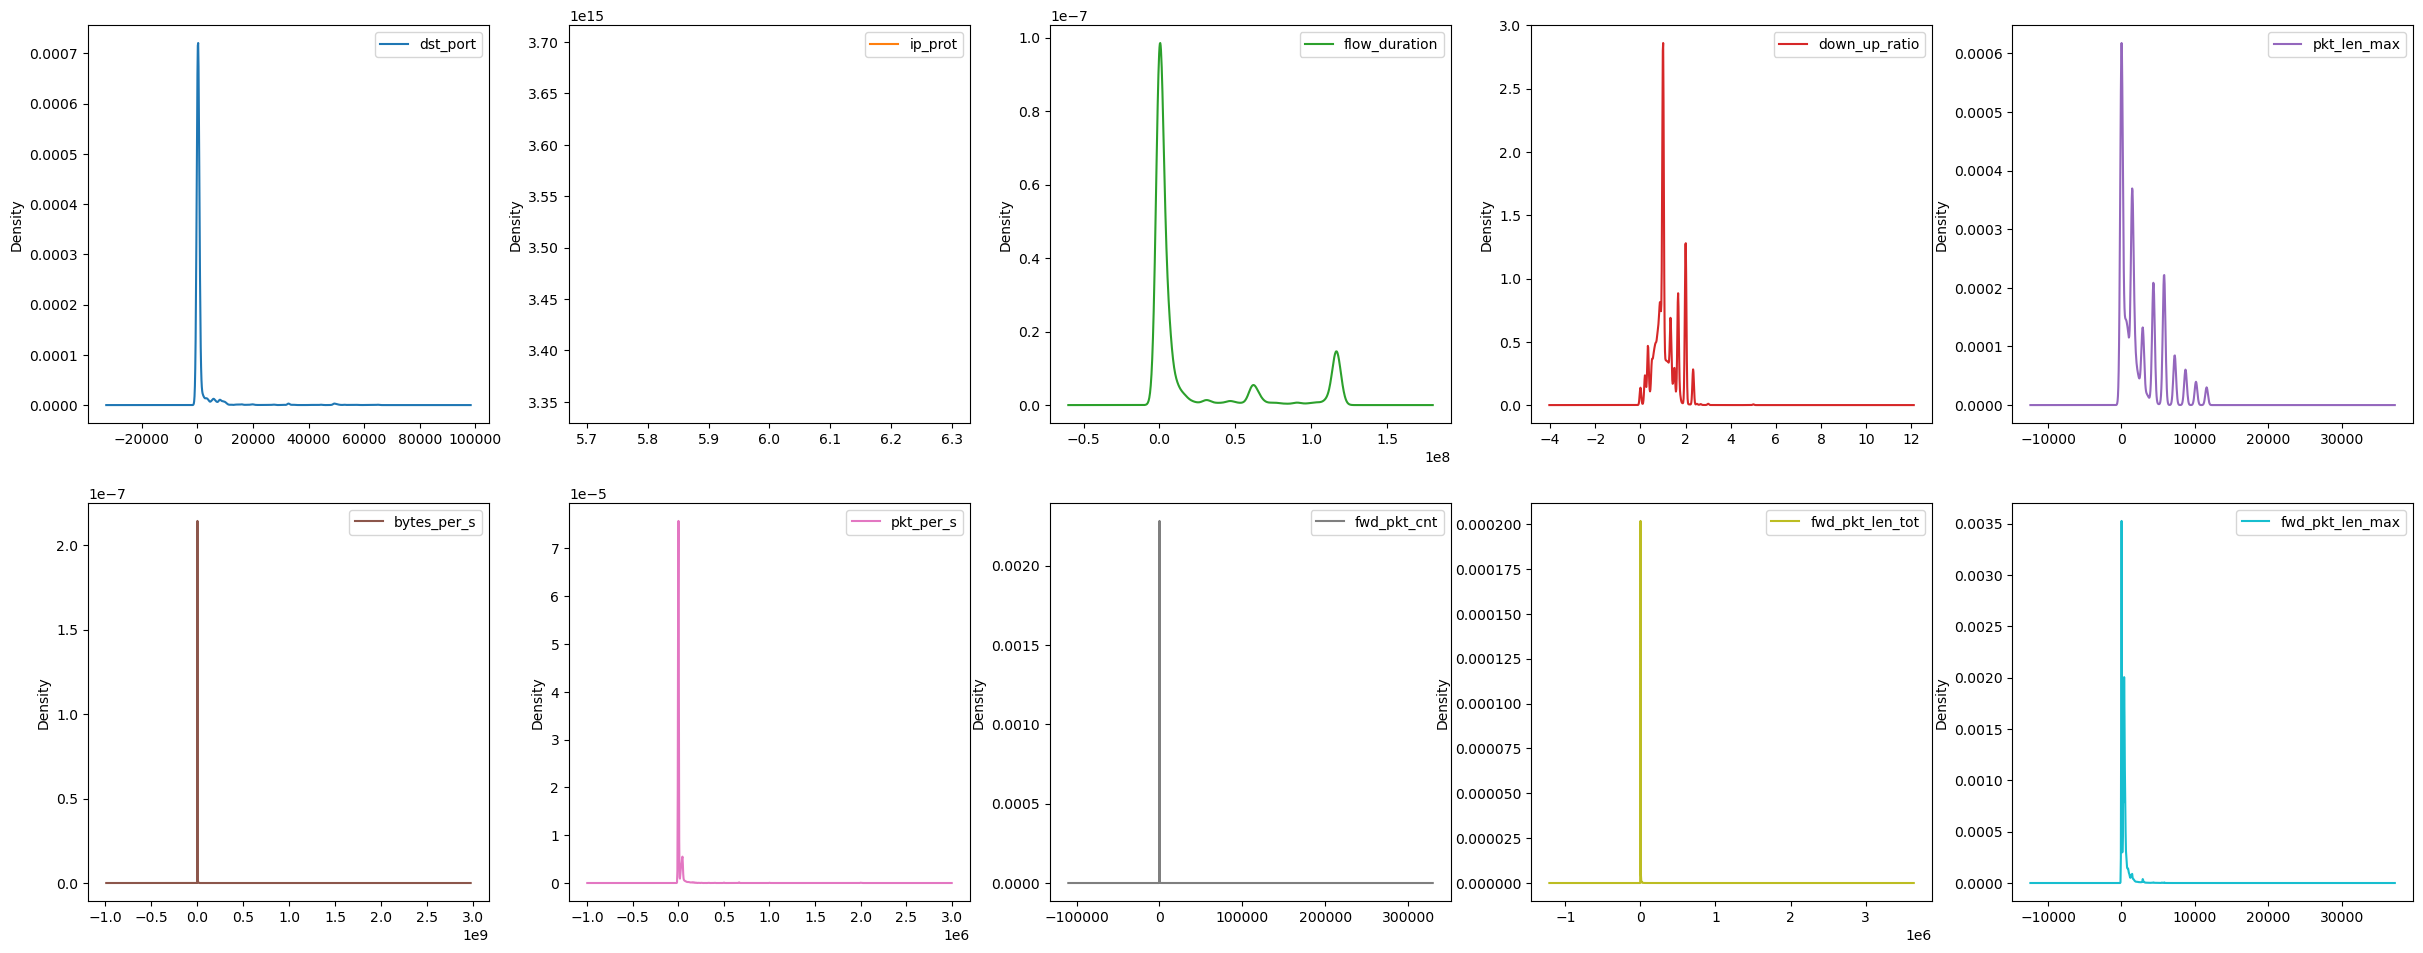

In [30]:
# Density plots
df.plot(kind='density', subplots=True, figsize=(30,30), layout=(5,5), sharex=False, sharey=False,
fontsize=None)
plt.show()

# Bivariate Analysis - Linear correlation (absolute threshold of 0.5)

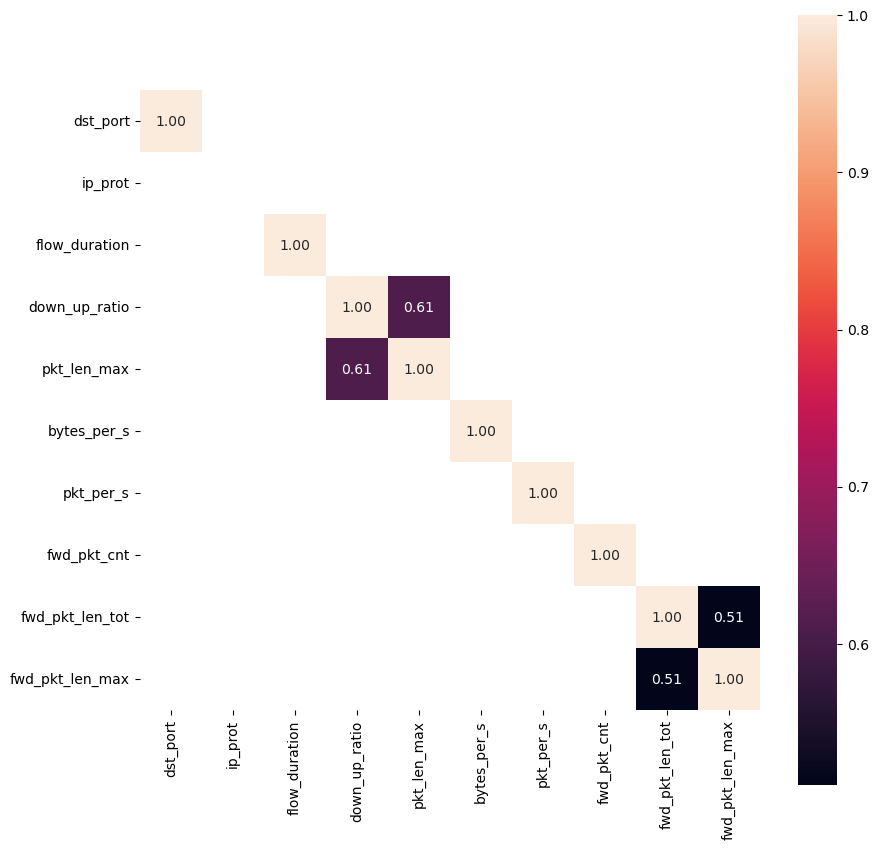

In [31]:
high_corr = features.corr().abs().round(2)
high_corr_var = high_corr[high_corr>0.5]
plt.figure(figsize = (10,10))
sns.heatmap(high_corr_var, fmt='.2f', square=True, xticklabels=high_corr_var.columns, yticklabels=high_corr_var.columns, annot=True);

# Machine Learning - Binary Classification

In [32]:
df.label[df.label == "benign"] = 0 # convert bonafide label to 0
df.label[df.label != 0] = 1 # convert attack labels to 1
df['label'].value_counts()

label
0    507992
1    441823
Name: count, dtype: int64

In [33]:
X = df.drop(columns = ["label"])
y = df.label
#X = X.astype(int) # convert to integers
y = y.astype(int)
print(X.shape, y.shape)

(949815, 10) (949815,)


# Spot checking DT, KNN, RF and SVM models

In [34]:
# Test options and evaluation metric
num_folds = 10
seed = 42
shuffle = True
scoring = 'f1'
validation_size = 0.20

# Spot-Check Algorithms
models = []
models.append(('DT', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))

In [35]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y,
test_size=validation_size, random_state=seed)

In [36]:
from sklearn.dummy import DummyClassifier
dummy_majority = DummyClassifier().fit(X_train, Y_train)
dummy_preds = dummy_majority.predict(X_validation)
print("Dummy classifier test score: {:.4f}".format(dummy_majority.score(X_validation, Y_validation)))

Dummy classifier test score: 0.5364


In [37]:
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

results = []
names = []
for name, model in models:
    cv_results = cross_val_score(model, X_train.values, Y_train.values, cv=kfold, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.4f (%.4f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


DT: 0.9947 (0.0003)
KNN: 0.9847 (0.0003)
SVM: 0.8181 (0.0010)
RF: 0.9951 (0.0003)


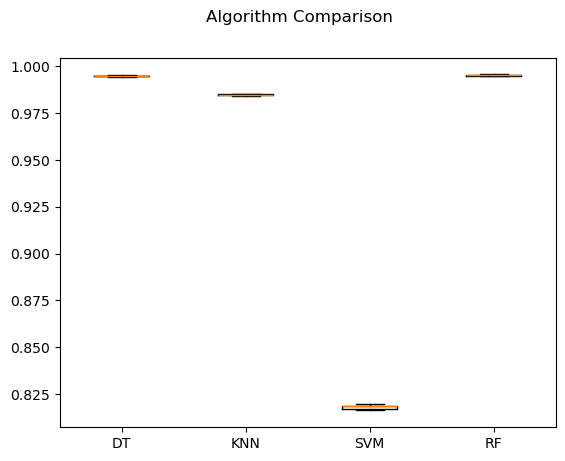

In [38]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [39]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN',KNeighborsClassifier())])))
pipelines.append(('ScaledDT', Pipeline([('Scaler', StandardScaler()),('DT', DecisionTreeClassifier())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier())])))

kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)

results = []
names = []
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train.values, Y_train.values, cv=kfold, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.4f (%.4f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledKNN: 0.9953 (0.0002)
ScaledDT: 0.9948 (0.0003)
ScaledSVM: 0.9822 (0.0005)
ScaledRF: 0.9967 (0.0002)


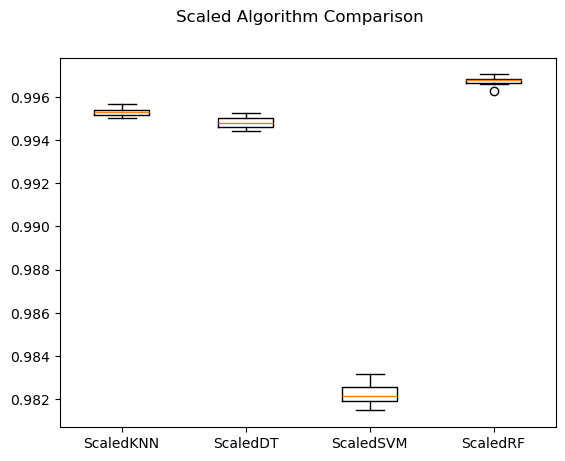

In [40]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Hyperparameter tuning based on the works of [2] and [3]

In [41]:
# hyperparameter tuning

algorithms = {
    "DT" : (DecisionTreeClassifier(), {
        "criterion": ("gini", "entropy"), 
        "max_depth": [x for x in range(1,21)],
        "class_weight": (None, "balanced")
    }),
    "KNN" :(KNeighborsClassifier(), {
        "n_neighbors": [x for x in range(1,31)],
        "weights": ["uniform", "distance"]
    }),
    "RF" : (RandomForestClassifier(), {
        "n_estimators": (1,100),
        "max_depth": [x for x in range(1,7)],
        "class_weight": (None, "balanced")
    }),
}

# Randomized Search
## Reducing computational expense. The code of [1] is adapted to use RandomizedSearchCV for hyperparameter tuning

In [42]:
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed) # Train, Test
rskf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed) # Validation
perf = f1_score # can be used roc_auc_score for binary classification

score = {}
results = {}
estimator = {}
for algorithm in algorithms.keys():
    score[algorithm] = []
    results[algorithm] = { 'expected': [], 'predicted': [] }
    estimator[algorithm] = []

for algorithm, (clf, parameters) in algorithms.items():
    print(algorithm)
    for train, test in kf.split(X, y):
        prep = StandardScaler()
        prep.fit(X.iloc[train])
        best = RandomizedSearchCV(clf, parameters, cv=rskf, scoring=make_scorer(perf), n_jobs=-1)
        best.fit(prep.transform(X.iloc[train]), y.iloc[train])
        score[algorithm].append(perf(best.predict(prep.transform(X.iloc[test])), y.iloc[test]))
        results[algorithm]['expected'].extend(y.iloc[test])
        results[algorithm]['predicted'].extend(best.predict_proba(prep.transform(X.iloc[test])).transpose()[1])
    print("Best parameters: {}".format(best.best_params_))
    print("Best cross-validation score: {:.4f}".format(best.best_score_))
    print("Best estimator:\n{}".format(best.best_estimator_))
    estimator[algorithm] = best.best_estimator_
    print("\n")

DT
Best parameters: {'max_depth': 17, 'criterion': 'entropy', 'class_weight': None}
Best cross-validation score: 0.9965
Best estimator:
DecisionTreeClassifier(criterion='entropy', max_depth=17)


KNN
Best parameters: {'weights': 'distance', 'n_neighbors': 9}
Best cross-validation score: 0.9948
Best estimator:
KNeighborsClassifier(n_neighbors=9, weights='distance')


RF
Best parameters: {'n_estimators': 100, 'max_depth': 6, 'class_weight': 'balanced'}
Best cross-validation score: 0.9910
Best estimator:
RandomForestClassifier(class_weight='balanced', max_depth=6)




In [43]:
# f1-scores
pd.DataFrame.from_dict(score)

,DT,KNN,RF
0,0.996339,0.994789,0.990644
1,0.996917,0.995570,0.985340
2,0.996293,0.995277,0.980226
3,0.996622,0.995244,0.984244
4,0.996735,0.995300,0.977679
5,0.996758,0.995257,0.990519
6,0.996668,0.995346,0.991582
7,0.996712,0.995459,0.983667
8,0.996361,0.994927,0.989982
9,0.996713,0.994796,0.991860


In [44]:
dt=estimator["DT"]
knn=estimator["KNN"]
rf=estimator["RF"]

In [45]:
pipelines = []
pipelines.append(('KNN', Pipeline([('Scaler', StandardScaler()), ('KNN',knn)])))
pipelines.append(('DT', Pipeline([('Scaler', StandardScaler()),('DT', dt)])))
pipelines.append(('RF', Pipeline([('Scaler', StandardScaler()),('RF', rf)])))

Model name:  KNN
              precision    recall  f1-score   support

      benign     0.9954    0.9957    0.9955    101905
      attack     0.9950    0.9947    0.9948     88058

    accuracy                         0.9952    189963
   macro avg     0.9952    0.9952    0.9952    189963
weighted avg     0.9952    0.9952    0.9952    189963



Model name:  DT
              precision    recall  f1-score   support

      benign     0.9952    0.9987    0.9969    101905
      attack     0.9985    0.9944    0.9964     88058

    accuracy                         0.9967    189963
   macro avg     0.9968    0.9965    0.9967    189963
weighted avg     0.9967    0.9967    0.9967    189963



Model name:  RF
              precision    recall  f1-score   support

      benign     0.9860    0.9962    0.9911    101905
      attack     0.9955    0.9836    0.9895     88058

    accuracy                         0.9904    189963
   macro avg     0.9908    0.9899    0.9903    189963
weighted avg     0.99

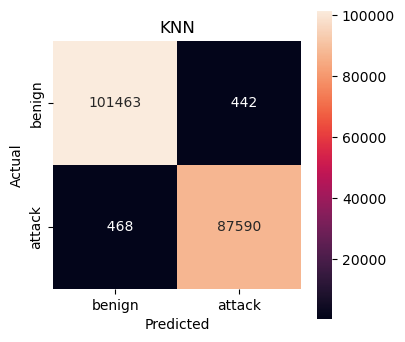

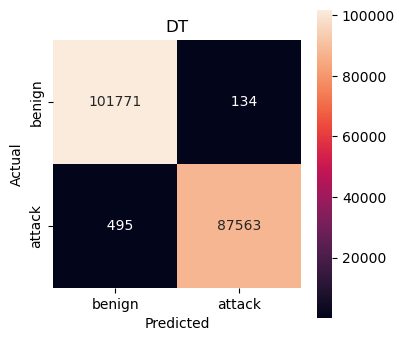

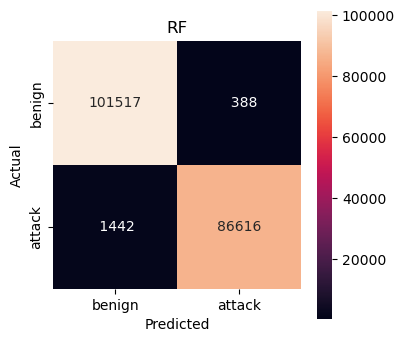

In [46]:
name = []
for name, model in pipelines:
    model_test = model.fit(X_train.values,Y_train.values).predict(X_validation.values)
    print("Model name: ",name)
    print(classification_report(Y_validation.values, model_test, digits=4, target_names=['benign','attack']))
    print("\n")
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    cm = confusion_matrix(Y_validation.values, model_test)
    ax = sns.heatmap(cm, annot=True, fmt='5g', square=True, xticklabels=['benign','attack'], yticklabels=['benign','attack'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(name)

## ROC/AUC evaluation

In [47]:
plt.style.use('plot_style.txt')

# ROC/AUC scores for the best set of parameters from the Grid Search above (for each k-fold)
for algorithm in algorithms.keys():
    roc_auc = roc_auc_score(results[algorithm]['expected'], results[algorithm]['predicted'])
    print('AUC(%s) = %.4f' % (algorithm, roc_auc))

AUC(DT) = 0.9993
AUC(KNN) = 0.9977
AUC(RF) = 0.9985


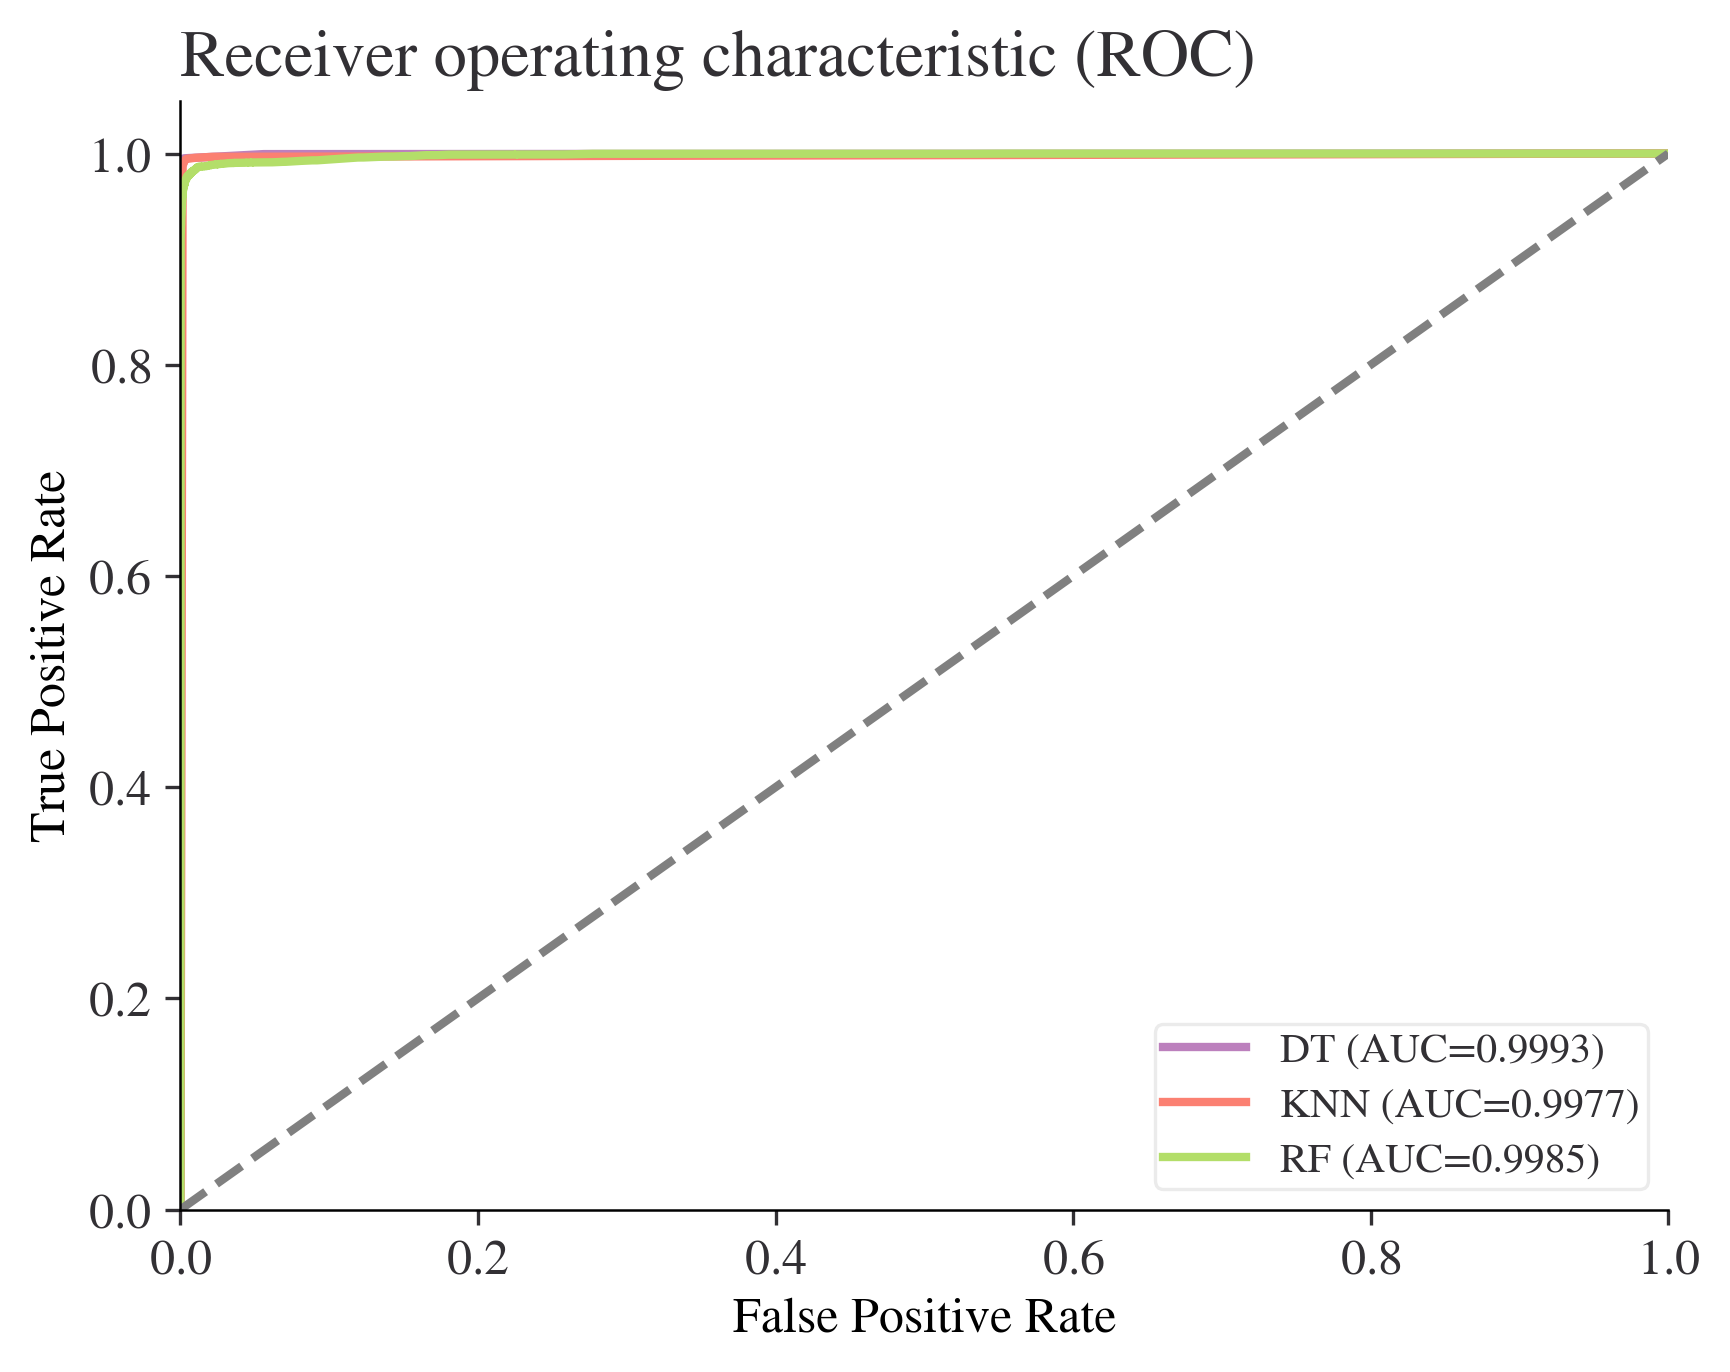

In [48]:
plt.figure()

#index = 0
for model_key, result in results.items():
    fpr, tpr, thresholds = roc_curve(result['expected'], result['predicted'])
    AUC = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label="{} (AUC={:.4f})".format(model_key, AUC))
    #index = index + 1
    # save ROC data
    #filename = 'data/LAN_'+model_key+'_ROC_data.csv'
    #pd.DataFrame.from_dict(data={ 'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds }).to_csv(filename, index=False)
    
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")

#plt.savefig(os.path.join('images/', 'roc_lan_models.pdf'), dpi=300, bbox_inches="tight")

## Generate the models

### Prepare data - Pre-processing for ML

In [49]:
prep = StandardScaler().fit(X)

### Save the trained models

In [50]:
dt = dt.fit(prep.transform(X),y)
knn = knn.fit(prep.transform(X),y)
rf = rf.fit(prep.transform(X),y)

In [52]:
from joblib import dump
dump(prep, open('Models/preprocessor.pkl', 'wb'))

In [53]:
dump(dt, open('Models/dt.pkl', 'wb'))
dump(knn, open('Models/knn.pkl', 'wb'))
dump(rf, open('Models/rf.pkl', 'wb'))

# References
>[1] G. De Carvalho Bertoli et al., “An End-to-End Framework for Machine Learning-Based Network Intrusion Detection System,” IEEE Access, vol. 9, pp. 106790–106805, 2021, doi: 10.1109/ACCESS.2021.3101188.\
>[2] A. Rosay, F. Carlier, E. Cheval, and P. Leroux, “From CIC-IDS2017 to LYCOS-IDS2017: A corrected dataset for better performance,” in IEEE/WIC/ACM International Conference on Web Intelligence, ESSENDON VIC Australia: ACM, Dec. 2021, pp. 570–575. doi: 10.1145/3486622.3493973.\
>[3] Z. K. Maseer, R. Yusof, N. Bahaman, S. A. Mostafa, and C. F. M. Foozy, “Benchmarking of machine learning for anomaly based intrusion detection systems in the CICIDS2017 dataset,” IEEE Access, vol. 9, pp. 22351–22370, 2021.

